In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.utils as vutils
from tqdm import tqdm

import os
import numpy as np
from PIL import Image

import random
import matplotlib.pyplot as plt


In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DTYPE = torch.float32
LEARNING_RATE_DISCRIMINATOR = 0.001
LEARNING_RATE_GENERATOR = 0.001
NUM_EPOCHS = 10 

### GENERATOR

In [56]:
class Generator_CNN(nn.Module):
    def __init__(self, device, dtype):
        super().__init__()
        self.device = device
        self.dtype = dtype
        
        self.project = nn.Linear(in_features=100, out_features=1024*4*4, device=self.device, dtype=self.dtype)

        self.conv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=3, stride=2, padding=1, device=self.device, dtype=self.dtype)
        self.bn1 = nn.BatchNorm2d(num_features=256, device=self.device, dtype=self.dtype)
        self.d1 = nn.Dropout2d(p=0.2)
        
        self.conv2 = nn.ConvTranspose2d(in_channels=256, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1, device=self.device, dtype=self.dtype)
        self.bn2 = nn.BatchNorm2d(num_features=32, device=self.device, dtype=self.dtype)
        self.d2 = nn.Dropout2d(p=0.2)
        
        self.conv3 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, device=self.device, dtype=self.dtype)
        self.bn3 = nn.BatchNorm2d(num_features=32, device=self.device, dtype=self.dtype)
        self.d3 = nn.Dropout2d(p=0.2)
        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1, device=self.device, dtype=self.dtype)
        

    def forward(self, x):

        x = self.project(x)
        x = F.tanh(x)
        x = x.reshape(-1, 1024, 4, 4)
        
        x = self.conv1(x, output_size=(-1, 512, 8, 8))
        x = self.bn1(x)
        x = F.tanh(x)
        x = self.d1(x)
        
        x = self.conv2(x, output_size=(-1, 256, 16, 16))
        x = self.bn2(x)
        x = F.tanh(x)
        x = self.d2(x)
        
        x = self.conv3(x, output_size=(-1, 128, 32, 32))
        x = self.bn3(x)
        x = F.tanh(x)
        x = self.d3(x)
        
        x = self.conv4(x)
        x = F.sigmoid(x)

        return x


torch.Size([1, 1, 32, 32])


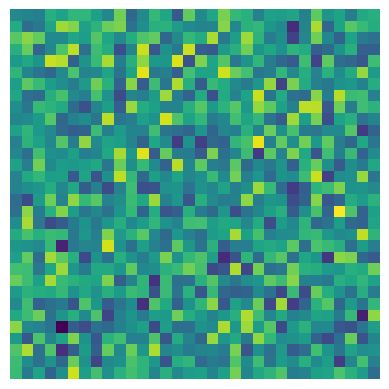

In [75]:
gen = Generator_CNN(DEVICE, DTYPE)
z = torch.rand(100, device=DEVICE, dtype=DTYPE)
x = gen.forward(z)
print(x.shape)
xx = x.to('cpu').detach().numpy().squeeze()
plt.imshow(xx, cmap='viridis')
plt.axis('off')
plt.show()

### DISCRIMINATOR

In [94]:
class Discriminator_CNN(nn.Module):
    def __init__(self, device, dtype):
        super().__init__()
        self.device = device
        self.dtype = dtype

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=2, device=self.device, dtype=self.dtype)
        self.bn1 = nn.BatchNorm2d(num_features=64, device=self.device, dtype=self.dtype)
        self.d1 = nn.Dropout2d(p=0.2)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, device=self.device, dtype=self.dtype)
        self.bn2 = nn.BatchNorm2d(num_features=128, device=self.device, dtype=self.dtype)
        self.d2 = nn.Dropout2d(p=0.2)
        
        self.linear1 = nn.Linear(in_features=128*5*5, out_features=100, device=self.device, dtype=self.dtype)
        self.bn3 = nn.BatchNorm1d(num_features=100, device=self.device, dtype=self.dtype)
        self.d3 = nn.Dropout1d(p=0.2)
        
        self.linear2 = nn.Linear(in_features=100, out_features=1, device=self.device, dtype=self.dtype)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.tanh(x)
        x = self.d1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.tanh(x)
        x = self.d2(x)

        x = x.reshape(-1, 128*5*5)

        x = self.linear1(x)
        x = x = F.tanh(x)

        x = self.linear2(x)
        x = F.sigmoid(x)
        return x

In [95]:
dis = Discriminator_CNN(DEVICE, DTYPE)
w = torch.randn((5, 1, 32, 32), device=DEVICE, dtype=DTYPE)
y = dis.forward(w)
y

tensor([[0.4707],
        [0.6459],
        [0.5081],
        [0.5491],
        [0.4579]], device='cuda:0', grad_fn=<SigmoidBackward0>)

## DATASET

In [91]:

def load_images_from_directory(root_dir):
    image_list = []
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                file_path = os.path.join(subdir, file)
                with Image.open(file_path) as img:
                    img_array = np.expand_dims(np.array(img), axis=0) #channel dimension
                    image_list.append(img_array)
    return image_list

root_directory = '/home/mtech1/gan/data/all'  
images = load_images_from_directory(root_directory)
print(f"Loaded {len(images)} images.")

BATCH_SIZE = 64

class devnagari(Dataset):
    def __init__(self, data, device, dtype):
        super().__init__()
        self.data = data
        self.device = device
        self.dtype = dtype

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index]
        img_tensor = torch.tensor(img, dtype=self.dtype, device=self.device)
        return img_tensor


real_dataset = devnagari(images, DEVICE, DTYPE)
real_dataloader = DataLoader(dataset=real_dataset,
                              batch_size=256, 
                              shuffle=True
                              )

images[0].shape

Loaded 92000 images.


(1, 32, 32)

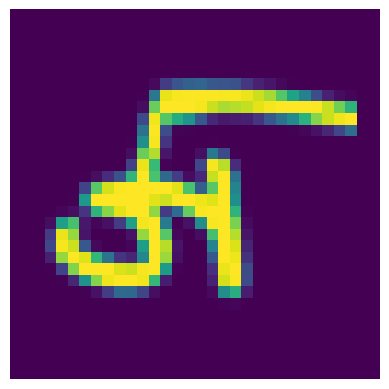

In [98]:
xxx = images[2].transpose(1,2,0)
plt.imshow(xxx, cmap='viridis')
plt.axis('off')
plt.show()

## Final GAN training

In [99]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DTYPE = torch.float32

BATCH_SIZE = 128
LEARNING_RATE = 0.0002
BETAS = (0.5, 0.999)
NUM_EPOCHS = 10 

In [100]:
class GAN(nn.Module):
    def __init__(self, device, dtype):
        super().__init__()
        self.device = device
        self.dtype = dtype
        self.generator = Generator_CNN(device=self.device, dtype=self.dtype)
        self.discriminator = Discriminator_CNN(device=self.device, dtype=self.dtype)
    
    def train_gan(self,
              device=DEVICE,
              dtype=DTYPE,
              real_data=real_dataloader,
              lr=LEARNING_RATE,
              betas=BETAS,
              num_epochs=NUM_EPOCHS,
              max_grad_norm=1.0):
        optimiser_G = optim.Adam(self.generator.parameters(), lr=0.0001, betas=betas)
        optimiser_D = optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=betas)
        criterion = nn.BCELoss()
        gen_loss = []
        disc_loss = []
        count = 0
        
        for epoch in tqdm(range(num_epochs), desc="Epochs"):
            avg_gen_loss = 0
            avg_disc_loss = 0
            for real_batch in real_data:
                real_batch = real_batch #+ 0.15 * torch.randn_like(real_batch)
                B, C, H, W = real_batch.shape
                
                Z = torch.randn((B, 100), device=device, dtype=dtype)
                fake_batch = self.generator(Z)
    
                fake_labels = torch.ones(B, 1, device=device, dtype=dtype)
                real_labels = torch.zeros(B, 1, device=device, dtype=dtype)
                
                smooth_fake_labels = fake_labels - 0.1 * torch.rand(B, 1, device=device, dtype=dtype)
                smooth_real_labels = real_labels + 0.1 * torch.rand(B, 1, device=device, dtype=dtype)
                
                ## DISCRIMINATOR TRAINING
                optimiser_D.zero_grad()
                loss_d = 0
                
                real_discriminator_out = self.discriminator(real_batch)
                fake_discriminator_out = self.discriminator(fake_batch.detach())
                
                loss_d_real = criterion(real_discriminator_out, smooth_real_labels)
                loss_d_fake = criterion(fake_discriminator_out, smooth_fake_labels)
                loss_d += (loss_d_real + loss_d_fake) / 2
                    
                loss_d.backward()
                torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), max_grad_norm)
                optimiser_D.step()
                    
                disc_loss.append(loss_d.item())
                avg_disc_loss += loss_d.item()
                
                
                ## GENERATOR TRAINING
                optimiser_G.zero_grad()
                loss_g = 0
                
                fake_discriminator_out = self.discriminator(fake_batch)
                loss_g += criterion(fake_discriminator_out, smooth_real_labels)
                loss_g.backward() 
                torch.nn.utils.clip_grad_norm_(self.generator.parameters(), max_grad_norm)                    
                optimiser_G.step()
                    
                gen_loss.append(loss_g.item())
                avg_gen_loss += loss_g.item()
                
                
            count += 1
            print(f'Epoch: {count}, Generator Loss: {avg_gen_loss/len(real_data):.4f}, Discriminator Loss: {avg_disc_loss/len(real_data):.4f}')
            
            if epoch % 1 == 0 or epoch == num_epochs - 1:
                self.monitor_generated_images(epoch, Z[:16], real_batch)  
            
        return gen_loss, disc_loss
    
            
    def monitor_generated_images(self, epoch, fixed_noise, real_batch, num_images=16, figsize=(20,10)):
        self.generator.eval()
        with torch.no_grad():
            fake_images = self.generator(fixed_noise).detach().cpu()
            real_images = real_batch[:num_images].cpu()
            
            fake_grid = vutils.make_grid(fake_images[:num_images], padding=2, normalize=True)
            real_grid = vutils.make_grid(real_images, padding=2, normalize=True)
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

            ax1.axis("off")
            ax1.set_title("Real Images")
            ax1.imshow(real_grid.permute(1, 2, 0).mean(dim=2), cmap='viridis')
            
            ax2.axis("off")
            ax2.set_title(f"Generated Images (Epoch {epoch+1})")
            ax2.imshow(fake_grid.permute(1, 2, 0).mean(dim=2), cmap='viridis') 

            plt.savefig(f'/home/mtech1/gan/images/DEV/comparison_epoch_{epoch+1}.png')
            plt.close(fig)




### **Training**

In [102]:
my_gan = GAN(device=DEVICE, dtype=DTYPE)

training_params={'device': DEVICE,
                 'dtype': DTYPE,
                 'real_data': real_dataloader,
                 'lr': 0.0002,
                 'betas': (0.5, 0.999),
                 'num_epochs': 100}

gen_loss, disc_loss = my_gan.train_gan(**training_params)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Generator Loss: 1.6569, Discriminator Loss: 0.3797


Epochs:   1%|          | 1/100 [00:09<15:17,  9.27s/it]

Epoch: 2, Generator Loss: 1.8307, Discriminator Loss: 0.3925


Epochs:   2%|▏         | 2/100 [00:18<14:47,  9.06s/it]

Epoch: 3, Generator Loss: 1.9217, Discriminator Loss: 0.3866


Epochs:   3%|▎         | 3/100 [00:27<14:33,  9.01s/it]

Epoch: 4, Generator Loss: 1.4227, Discriminator Loss: 0.4922


Epochs:   4%|▍         | 4/100 [00:36<14:21,  8.97s/it]

Epoch: 5, Generator Loss: 1.3818, Discriminator Loss: 0.4967


Epochs:   5%|▌         | 5/100 [00:44<14:10,  8.95s/it]

Epoch: 6, Generator Loss: 1.4644, Discriminator Loss: 0.4715


Epochs:   6%|▌         | 6/100 [00:53<14:01,  8.95s/it]

Epoch: 7, Generator Loss: 1.5554, Discriminator Loss: 0.4500


Epochs:   7%|▋         | 7/100 [01:02<13:55,  8.99s/it]

Epoch: 8, Generator Loss: 1.6537, Discriminator Loss: 0.4338


Epochs:   8%|▊         | 8/100 [01:12<13:50,  9.03s/it]

Epoch: 9, Generator Loss: 1.7364, Discriminator Loss: 0.4174


Epochs:   9%|▉         | 9/100 [01:21<13:43,  9.05s/it]

Epoch: 10, Generator Loss: 1.8011, Discriminator Loss: 0.4060


Epochs:  10%|█         | 10/100 [01:30<13:36,  9.07s/it]

Epoch: 11, Generator Loss: 1.8465, Discriminator Loss: 0.4008


Epochs:  11%|█         | 11/100 [01:39<13:27,  9.08s/it]

Epoch: 12, Generator Loss: 1.8780, Discriminator Loss: 0.3954


Epochs:  12%|█▏        | 12/100 [01:48<13:19,  9.08s/it]

Epoch: 13, Generator Loss: 1.9172, Discriminator Loss: 0.3901


Epochs:  13%|█▎        | 13/100 [01:57<13:04,  9.02s/it]

Epoch: 14, Generator Loss: 1.9447, Discriminator Loss: 0.3857


Epochs:  14%|█▍        | 14/100 [02:06<12:56,  9.03s/it]

Epoch: 15, Generator Loss: 1.9619, Discriminator Loss: 0.3821


Epochs:  15%|█▌        | 15/100 [02:15<12:43,  8.98s/it]

Epoch: 16, Generator Loss: 1.9897, Discriminator Loss: 0.3798


Epochs:  16%|█▌        | 16/100 [02:24<12:31,  8.94s/it]

Epoch: 17, Generator Loss: 2.0068, Discriminator Loss: 0.3779


Epochs:  17%|█▋        | 17/100 [02:33<12:30,  9.04s/it]

Epoch: 18, Generator Loss: 2.0233, Discriminator Loss: 0.3758


Epochs:  18%|█▊        | 18/100 [02:42<12:15,  8.97s/it]

Epoch: 19, Generator Loss: 2.0376, Discriminator Loss: 0.3749


Epochs:  19%|█▉        | 19/100 [02:50<11:55,  8.83s/it]

Epoch: 20, Generator Loss: 2.0497, Discriminator Loss: 0.3720


Epochs:  20%|██        | 20/100 [02:59<11:36,  8.70s/it]

Epoch: 21, Generator Loss: 2.0701, Discriminator Loss: 0.3721


Epochs:  21%|██        | 21/100 [03:08<11:37,  8.83s/it]

Epoch: 22, Generator Loss: 2.0703, Discriminator Loss: 0.3718


Epochs:  22%|██▏       | 22/100 [03:17<11:32,  8.87s/it]

Epoch: 23, Generator Loss: 2.0816, Discriminator Loss: 0.3706


Epochs:  23%|██▎       | 23/100 [03:26<11:26,  8.92s/it]

Epoch: 24, Generator Loss: 2.0895, Discriminator Loss: 0.3701


Epochs:  24%|██▍       | 24/100 [03:35<11:18,  8.93s/it]

Epoch: 25, Generator Loss: 2.1088, Discriminator Loss: 0.3688


Epochs:  25%|██▌       | 25/100 [03:44<11:13,  8.97s/it]

Epoch: 26, Generator Loss: 2.1091, Discriminator Loss: 0.3681


Epochs:  26%|██▌       | 26/100 [03:53<11:07,  9.01s/it]

Epoch: 27, Generator Loss: 2.1207, Discriminator Loss: 0.3681


Epochs:  27%|██▋       | 27/100 [04:02<10:59,  9.04s/it]

Epoch: 28, Generator Loss: 2.1304, Discriminator Loss: 0.3668


Epochs:  28%|██▊       | 28/100 [04:11<10:50,  9.04s/it]

Epoch: 29, Generator Loss: 2.1331, Discriminator Loss: 0.3669


Epochs:  29%|██▉       | 29/100 [04:20<10:41,  9.04s/it]

Epoch: 30, Generator Loss: 2.1428, Discriminator Loss: 0.3663


Epochs:  30%|███       | 30/100 [04:29<10:32,  9.03s/it]

Epoch: 31, Generator Loss: 2.1505, Discriminator Loss: 0.3663


Epochs:  31%|███       | 31/100 [04:38<10:22,  9.02s/it]

Epoch: 32, Generator Loss: 2.1558, Discriminator Loss: 0.3654


Epochs:  32%|███▏      | 32/100 [04:47<10:13,  9.02s/it]

Epoch: 33, Generator Loss: 2.1609, Discriminator Loss: 0.3653


Epochs:  33%|███▎      | 33/100 [04:56<10:03,  9.00s/it]

Epoch: 34, Generator Loss: 2.1541, Discriminator Loss: 0.3648


Epochs:  34%|███▍      | 34/100 [05:05<09:54,  9.00s/it]

Epoch: 35, Generator Loss: 2.1710, Discriminator Loss: 0.3659


Epochs:  35%|███▌      | 35/100 [05:14<09:43,  8.98s/it]

Epoch: 36, Generator Loss: 2.1713, Discriminator Loss: 0.3655


Epochs:  36%|███▌      | 36/100 [05:23<09:35,  8.99s/it]

Epoch: 37, Generator Loss: 2.1643, Discriminator Loss: 0.3649


Epochs:  37%|███▋      | 37/100 [05:32<09:22,  8.92s/it]

Epoch: 38, Generator Loss: 2.1735, Discriminator Loss: 0.3653


Epochs:  38%|███▊      | 38/100 [05:41<09:13,  8.92s/it]

Epoch: 39, Generator Loss: 2.1790, Discriminator Loss: 0.3652


Epochs:  39%|███▉      | 39/100 [05:50<09:05,  8.94s/it]

Epoch: 40, Generator Loss: 2.1779, Discriminator Loss: 0.3657


Epochs:  40%|████      | 40/100 [05:59<08:56,  8.95s/it]

Epoch: 41, Generator Loss: 2.1855, Discriminator Loss: 0.3652


Epochs:  41%|████      | 41/100 [06:08<08:48,  8.95s/it]

Epoch: 42, Generator Loss: 2.1827, Discriminator Loss: 0.3649


Epochs:  42%|████▏     | 42/100 [06:17<08:39,  8.97s/it]

Epoch: 43, Generator Loss: 2.1918, Discriminator Loss: 0.3638


Epochs:  43%|████▎     | 43/100 [06:26<08:30,  8.96s/it]

Epoch: 44, Generator Loss: 2.1980, Discriminator Loss: 0.3644


Epochs:  44%|████▍     | 44/100 [06:35<08:22,  8.98s/it]

Epoch: 45, Generator Loss: 2.2036, Discriminator Loss: 0.3629


Epochs:  45%|████▌     | 45/100 [06:44<08:14,  8.98s/it]

Epoch: 46, Generator Loss: 2.2165, Discriminator Loss: 0.3633


Epochs:  46%|████▌     | 46/100 [06:53<08:05,  8.98s/it]

Epoch: 47, Generator Loss: 2.2032, Discriminator Loss: 0.3634


Epochs:  47%|████▋     | 47/100 [07:02<07:56,  8.99s/it]

Epoch: 48, Generator Loss: 2.2091, Discriminator Loss: 0.3631


Epochs:  48%|████▊     | 48/100 [07:11<07:48,  9.00s/it]

Epoch: 49, Generator Loss: 2.2112, Discriminator Loss: 0.3633


Epochs:  49%|████▉     | 49/100 [07:20<07:38,  9.00s/it]

Epoch: 50, Generator Loss: 2.2110, Discriminator Loss: 0.3629


Epochs:  50%|█████     | 50/100 [07:29<07:29,  8.99s/it]

Epoch: 51, Generator Loss: 2.2223, Discriminator Loss: 0.3627


Epochs:  51%|█████     | 51/100 [07:38<07:20,  8.99s/it]

Epoch: 52, Generator Loss: 2.2246, Discriminator Loss: 0.3639


Epochs:  52%|█████▏    | 52/100 [07:46<07:11,  8.98s/it]

Epoch: 53, Generator Loss: 2.2220, Discriminator Loss: 0.3631


Epochs:  53%|█████▎    | 53/100 [07:56<07:06,  9.07s/it]

Epoch: 54, Generator Loss: 2.2413, Discriminator Loss: 0.3618


Epochs:  54%|█████▍    | 54/100 [08:05<06:55,  9.03s/it]

Epoch: 55, Generator Loss: 2.2316, Discriminator Loss: 0.3625


Epochs:  55%|█████▌    | 55/100 [08:14<06:47,  9.04s/it]

Epoch: 56, Generator Loss: 2.2405, Discriminator Loss: 0.3614


Epochs:  56%|█████▌    | 56/100 [08:23<06:38,  9.07s/it]

Epoch: 57, Generator Loss: 2.2305, Discriminator Loss: 0.3615


Epochs:  57%|█████▋    | 57/100 [08:32<06:30,  9.08s/it]

Epoch: 58, Generator Loss: 2.2334, Discriminator Loss: 0.3623


Epochs:  58%|█████▊    | 58/100 [08:41<06:21,  9.09s/it]

Epoch: 59, Generator Loss: 2.2332, Discriminator Loss: 0.3614


Epochs:  59%|█████▉    | 59/100 [08:50<06:12,  9.10s/it]

Epoch: 60, Generator Loss: 2.2437, Discriminator Loss: 0.3614


Epochs:  60%|██████    | 60/100 [08:59<06:02,  9.07s/it]

Epoch: 61, Generator Loss: 2.2460, Discriminator Loss: 0.3616


Epochs:  61%|██████    | 61/100 [09:08<05:52,  9.03s/it]

Epoch: 62, Generator Loss: 2.2446, Discriminator Loss: 0.3613


Epochs:  62%|██████▏   | 62/100 [09:17<05:42,  9.02s/it]

Epoch: 63, Generator Loss: 2.2466, Discriminator Loss: 0.3608


Epochs:  63%|██████▎   | 63/100 [09:26<05:33,  9.01s/it]

Epoch: 64, Generator Loss: 2.2466, Discriminator Loss: 0.3609


Epochs:  64%|██████▍   | 64/100 [09:35<05:23,  9.00s/it]

Epoch: 65, Generator Loss: 2.2457, Discriminator Loss: 0.3622


Epochs:  65%|██████▌   | 65/100 [09:44<05:15,  9.01s/it]

Epoch: 66, Generator Loss: 2.2492, Discriminator Loss: 0.3605


Epochs:  66%|██████▌   | 66/100 [09:53<05:05,  8.98s/it]

Epoch: 67, Generator Loss: 2.2434, Discriminator Loss: 0.3618


Epochs:  67%|██████▋   | 67/100 [10:02<04:55,  8.97s/it]

Epoch: 68, Generator Loss: 2.2578, Discriminator Loss: 0.3609


Epochs:  68%|██████▊   | 68/100 [10:11<04:46,  8.96s/it]

Epoch: 69, Generator Loss: 2.2567, Discriminator Loss: 0.3611


Epochs:  69%|██████▉   | 69/100 [10:20<04:38,  8.97s/it]

Epoch: 70, Generator Loss: 2.2547, Discriminator Loss: 0.3604


Epochs:  70%|███████   | 70/100 [10:29<04:28,  8.96s/it]

Epoch: 71, Generator Loss: 2.2558, Discriminator Loss: 0.3603


Epochs:  71%|███████   | 71/100 [10:38<04:19,  8.96s/it]

Epoch: 72, Generator Loss: 2.2626, Discriminator Loss: 0.3613


Epochs:  72%|███████▏  | 72/100 [10:47<04:10,  8.96s/it]

Epoch: 73, Generator Loss: 2.2665, Discriminator Loss: 0.3616


Epochs:  73%|███████▎  | 73/100 [10:56<04:01,  8.95s/it]

Epoch: 74, Generator Loss: 2.2605, Discriminator Loss: 0.3605


Epochs:  74%|███████▍  | 74/100 [11:05<03:53,  8.99s/it]

Epoch: 75, Generator Loss: 2.2688, Discriminator Loss: 0.3608


Epochs:  75%|███████▌  | 75/100 [11:14<03:45,  9.01s/it]

Epoch: 76, Generator Loss: 2.2567, Discriminator Loss: 0.3608


Epochs:  76%|███████▌  | 76/100 [11:23<03:35,  9.00s/it]

Epoch: 77, Generator Loss: 2.2633, Discriminator Loss: 0.3600


Epochs:  77%|███████▋  | 77/100 [11:32<03:26,  8.99s/it]

Epoch: 78, Generator Loss: 2.2714, Discriminator Loss: 0.3599


Epochs:  78%|███████▊  | 78/100 [11:41<03:17,  8.98s/it]

Epoch: 79, Generator Loss: 2.2635, Discriminator Loss: 0.3596


Epochs:  79%|███████▉  | 79/100 [11:50<03:08,  8.98s/it]

Epoch: 80, Generator Loss: 2.2666, Discriminator Loss: 0.3612


Epochs:  80%|████████  | 80/100 [11:59<02:59,  8.96s/it]

Epoch: 81, Generator Loss: 2.2681, Discriminator Loss: 0.3589


Epochs:  81%|████████  | 81/100 [12:08<02:50,  8.96s/it]

Epoch: 82, Generator Loss: 2.2581, Discriminator Loss: 0.3602


Epochs:  82%|████████▏ | 82/100 [12:17<02:42,  9.00s/it]

Epoch: 83, Generator Loss: 2.2653, Discriminator Loss: 0.3597


Epochs:  83%|████████▎ | 83/100 [12:26<02:33,  9.02s/it]

Epoch: 84, Generator Loss: 2.2831, Discriminator Loss: 0.3574


Epochs:  84%|████████▍ | 84/100 [12:35<02:24,  9.04s/it]

Epoch: 85, Generator Loss: 2.2692, Discriminator Loss: 0.3581


Epochs:  85%|████████▌ | 85/100 [12:44<02:15,  9.04s/it]

Epoch: 86, Generator Loss: 2.2759, Discriminator Loss: 0.3600


Epochs:  86%|████████▌ | 86/100 [12:53<02:06,  9.02s/it]

Epoch: 87, Generator Loss: 2.2753, Discriminator Loss: 0.3596


Epochs:  87%|████████▋ | 87/100 [13:02<01:57,  9.01s/it]

Epoch: 88, Generator Loss: 2.2760, Discriminator Loss: 0.3593


Epochs:  88%|████████▊ | 88/100 [13:11<01:48,  9.01s/it]

Epoch: 89, Generator Loss: 2.2878, Discriminator Loss: 0.3576


Epochs:  89%|████████▉ | 89/100 [13:20<01:39,  9.02s/it]

Epoch: 90, Generator Loss: 2.2748, Discriminator Loss: 0.3594


Epochs:  90%|█████████ | 90/100 [13:29<01:30,  9.02s/it]

Epoch: 91, Generator Loss: 2.2864, Discriminator Loss: 0.3587


Epochs:  91%|█████████ | 91/100 [13:38<01:21,  9.03s/it]

Epoch: 92, Generator Loss: 2.2840, Discriminator Loss: 0.3582


Epochs:  92%|█████████▏| 92/100 [13:47<01:12,  9.03s/it]

Epoch: 93, Generator Loss: 2.2871, Discriminator Loss: 0.3587


Epochs:  93%|█████████▎| 93/100 [13:56<01:03,  9.01s/it]

Epoch: 94, Generator Loss: 2.2841, Discriminator Loss: 0.3584


Epochs:  94%|█████████▍| 94/100 [14:05<00:54,  9.03s/it]

Epoch: 95, Generator Loss: 2.2878, Discriminator Loss: 0.3581


Epochs:  95%|█████████▌| 95/100 [14:14<00:45,  9.03s/it]

Epoch: 96, Generator Loss: 2.2907, Discriminator Loss: 0.3577


Epochs:  96%|█████████▌| 96/100 [14:23<00:36,  9.03s/it]

Epoch: 97, Generator Loss: 2.2915, Discriminator Loss: 0.3588


Epochs:  97%|█████████▋| 97/100 [14:32<00:27,  9.02s/it]

Epoch: 98, Generator Loss: 2.2809, Discriminator Loss: 0.3584


Epochs:  98%|█████████▊| 98/100 [14:41<00:18,  9.11s/it]

Epoch: 99, Generator Loss: 2.2927, Discriminator Loss: 0.3580


Epochs:  99%|█████████▉| 99/100 [14:50<00:09,  9.09s/it]

Epoch: 100, Generator Loss: 2.2871, Discriminator Loss: 0.3580


Epochs: 100%|██████████| 100/100 [14:59<00:00,  9.00s/it]


In [ ]:
gen_loss

Model Test: 10 epochs; k = 5

In [1]:
#my_gan = torch.load('/home/mtech1/gan/my_gan')
noise = torch.rand((1, 100, 3, 3), device=DEVICE, dtype=DTYPE) 
xx = my_gan.generator.forward(noise).to('cpu').detach().numpy().squeeze()
plt.imshow(xx)
plt.axis('off')
plt.show()



NameError: name 'torch' is not defined

Model Test: 10+20 epochs; k = 6

## GAN sample Generations

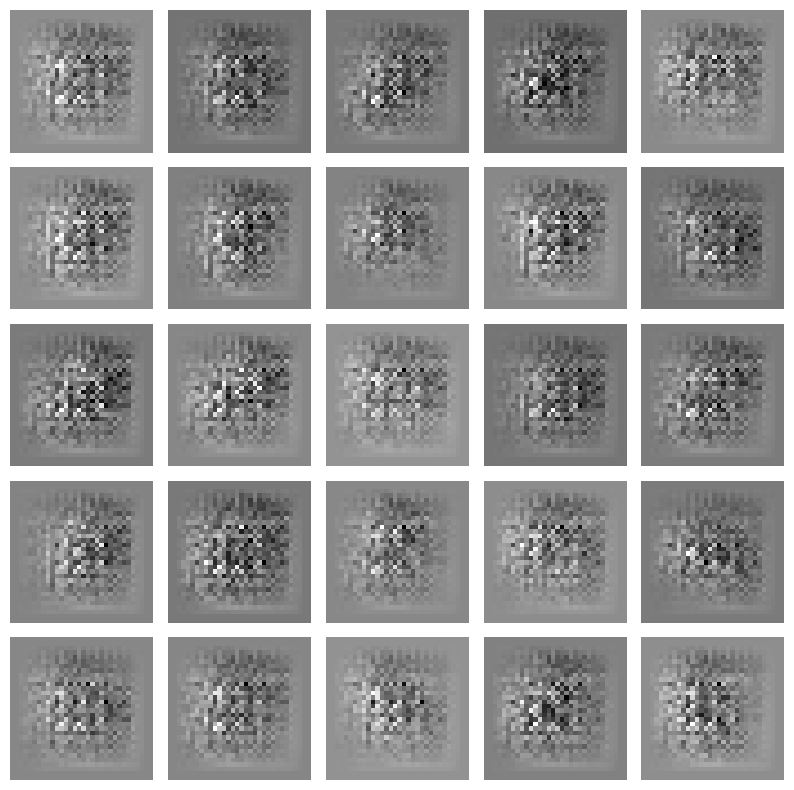

In [294]:
num_images = 25
grid_size = 5

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for i in range(grid_size):
    for j in range(grid_size):
        noise = torch.rand((1, 1, 3, 3), device=DEVICE, dtype=DTYPE) 
        sample_img = my_gan.generator.forward(noise)
    
        image = sample_img.squeeze(0).to('cpu') 
        image_np = image.detach().numpy().squeeze()
        
        axes[i, j].imshow(image_np, cmap='gray')
        axes[i, j].axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1) 
plt.show()

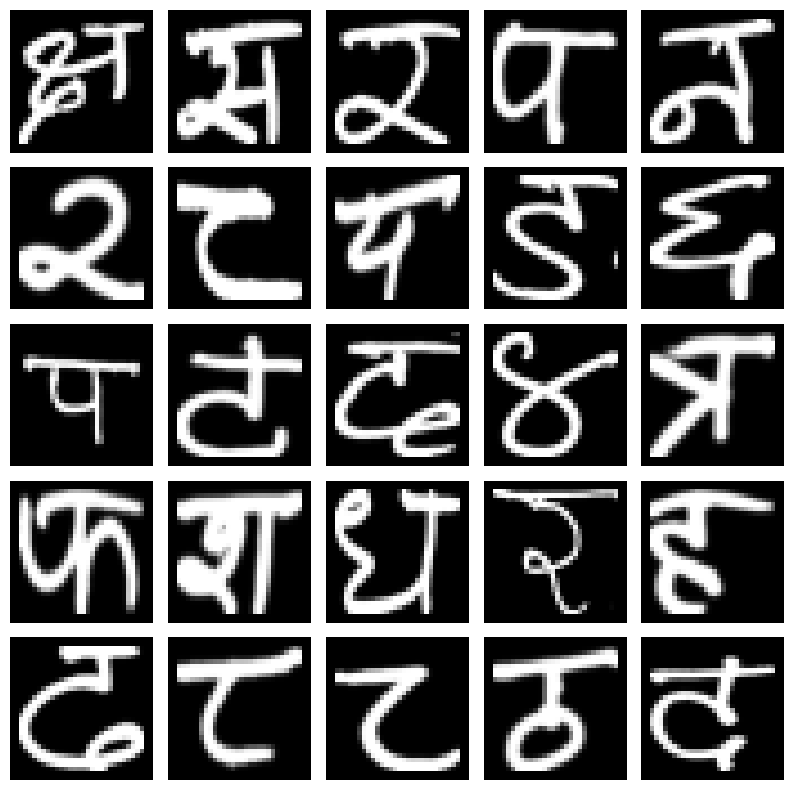

In [295]:
num_images = 25
grid_size = 5

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
data_list = list(real_dataset)
sampled_images = random.sample(data_list, num_images)

for i in range(grid_size):
    for j in range(grid_size):
        image = sampled_images[i * grid_size + j]
        if image.shape[0] == 1:
            image = image.squeeze(0)
        else:
            image = np.transpose(image, (1, 2, 0)) 
        if isinstance(image, torch.Tensor):
            image = image.detach().cpu().numpy()
        axes[i, j].imshow(image, cmap='gray' if image.ndim == 2 else None)
        axes[i, j].axis('off')  
plt.subplots_adjust(wspace=0.1, hspace=0.1) 
plt.show()

In [2]:
import torch 

In [8]:
a = torch.tensor([1, 2, 3], requires_grad=True, dtype=torch.float32); b = torch.tensor([4, 5, 6], requires_grad=True, dtype=torch.float32)
c = 2*a + 3*b; d = 3*a + 2*b
c.backward()
print(a.grad, b.grad, c.grad)
d.backward()
print(a.grad, b.grad, c.grad)

RuntimeError: grad can be implicitly created only for scalar outputs

In [4]:
b = torch.tensor([4, 5, 6])
print(b.grad)

None
